In [28]:
import numpy as np
import tensorflow as tf
import cv2

slim = tf.contrib.slim
from tensorflow.contrib.slim.python.slim import queues

In [29]:
import sys
sys.path.append('../')

In [30]:
from datasets import dataset_factory
from nets import nets_factory
from preprocessing import preprocessing_factory

In [31]:
isess = tf.InteractiveSession()

## Drawing routines

In [32]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """Draw a collection of lines on an image.
    """
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def draw_rectangle(img, p1, p2, color=[255, 0, 0], thickness=2):
    cv2.rectangle(img, p1[::-1], p2[::-1], color, thickness)
    
    
def draw_bbox(img, bbox, shape, label, color=[255, 0, 0], thickness=2):
    p1 = (int(bbox[0] * shape[0]), int(bbox[1] * shape[1]))
    p2 = (int(bbox[2] * shape[0]), int(bbox[3] * shape[1]))
    cv2.rectangle(img, p1[::-1], p2[::-1], color, thickness)
    p1 = (p1[0]+15, p1[1])
    cv2.putText(img, str(label), p1[::-1], cv2.FONT_HERSHEY_DUPLEX, 0.5, color, 1)
    

## Pascal VOC dataset

Check the data pipeline and TFRecords files.

In [33]:
from datasets import pascalvoc_2007
from datasets import pascalvoc_2012

DATASET_DIR = '/media/paul/DataExt4/PascalVOC/dataset/'
SPLIT_NAME = 'train'
BATCH_SIZE = 16

# Dataset provider loading data from the dataset.
dataset = pascalvoc_2007.get_split(SPLIT_NAME, DATASET_DIR)
provider = slim.dataset_data_provider.DatasetDataProvider(dataset, shuffle=False,
                                                          common_queue_capacity=2 * BATCH_SIZE,
                                                          common_queue_min=BATCH_SIZE)
[image, shape, bbox, label] = provider.get(['image', 'shape', 'object/bbox', 'object/label'])
print('Dataset:', dataset.data_sources)

Dataset: /media/paul/DataExt4/PascalVOC/dataset/voc_2007_train.tfrecord


In [34]:
# Problem: image shape is not fully defined => random crop with deterministic size.
xy = tf.random_uniform((2, ), minval=0, maxval=shape[0] // 3, dtype=tf.int64)
image_crop = tf.slice(image, [0, 0, 0], [200, 200, 3])

print(image.get_shape())
print(image_crop.get_shape())
print(bbox.get_shape())
print(label.get_shape())

(?, ?, 3)
(200, 200, 3)
(?, 4)
(?,)


In [35]:
# Read records from the queue.
with tf.Session() as sess:
#     with queues.QueueRunners(sess):
    # Start populating the filename queue.
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    result = sess.run([image_crop, shape, bbox, label])
    result = sess.run([image_crop, shape, bbox, label])
    result = sess.run([image_crop, shape, bbox, label])
    
    # Request threads to stop. Just to avoid error messages
    coord.request_stop()
    coord.join(threads)


(200, 200, 3)
[375 500   3]
[[ 0.45866665  0.138       0.88        0.54000002]
 [ 0.37599999  0.30000001  0.75733334  0.458     ]
 [ 0.53600001  0.56999999  0.88266665  0.65399998]
 [ 0.528       0.51599997  0.87733334  0.59399998]]
[6 1 1 1]


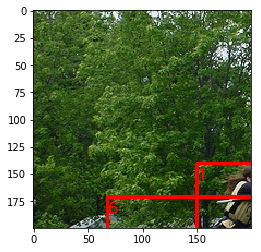

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = result[0]
img_shape = result[1]
bboxes = result[2]
for i in range(bboxes.shape[0]):
    draw_bbox(img, bboxes[i], img_shape, result[3][i], color=[255, 0, 0])

print(img.shape)
print(img_shape)
print(bboxes)
print(result[3])

plt.imshow(img)

In [37]:
images = tf.train.batch(
                [image_crop],
                batch_size=BATCH_SIZE,
                num_threads=1,
                capacity=5 * BATCH_SIZE)

In [38]:
# images.eval()

## Test original SSD-300 model

Restore model and test it on some random images.

In [39]:
_R_MEAN = 123.68
_G_MEAN = 116.78
_B_MEAN = 103.94

def _mean_image_subtraction(image, means):
    if image.get_shape().ndims != 3:
        raise ValueError('Input must be of size [height, width, C>0]')
    num_channels = image.get_shape().as_list()[-1]
    if len(means) != num_channels:
        raise ValueError('len(means) must match the number of channels')

    channels = tf.split(2, num_channels, image)
    for i in range(num_channels):
        channels[i] -= means[i]
    return tf.concat(2, channels)


def preprocess_for_eval(image):
#     image = tf.slice(image, [0, 0, 0], [300, 300, 3])
    image = tf.to_float(image)
    return _mean_image_subtraction(image, [_R_MEAN, _G_MEAN, _B_MEAN])

In [13]:
from nets import ssd_vgg

ckpt_filename = '/media/paul/DataExt4/PascalVOC/training/ckpts/SSD_300x300_ft/ssd_300_vgg.ckpt'

In [14]:
image_pre = preprocess_for_eval(image)
image_4d = tf.expand_dims(image_pre, 0)

arg_scope = ssd_vgg.ssd_300_vgg_arg_scope(weight_decay=0.0005)
with slim.arg_scope(arg_scope):
    predictions, localisations, end_points = ssd_vgg.ssd_300_vgg(image_4d, num_classes=21, is_training=False)

In [15]:
saver = tf.train.Saver()
init_op = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init_op)
    saver.restore(sess, ckpt_filename)
    
    # Start populating the filename queue.
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)

    # Load model weights.
    result = sess.run([image, predictions, localisations, end_points])
    result = sess.run([image, predictions, localisations, end_points])
    
    # Request threads to stop. Just to avoid error messages
    coord.request_stop()
    coord.join(threads)


In [16]:
print(image.get_shape())
print(image.dtype)

print(image_crop.get_shape())
print(image_crop.dtype)

print(image_pre.get_shape())
print(image_pre.dtype)

(?, ?, 3)
<dtype: 'uint8'>
(200, 200, 3)
<dtype: 'uint8'>
(?, ?, 3)
<dtype: 'float32'>


In [17]:
img = result[0]
img_pred = result[1]
img_loc = result[2]
img_end_points = result[3]

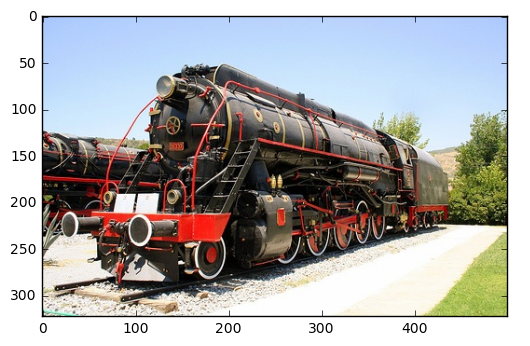

In [18]:
plt.imshow(img)

In [54]:
print('Image', img.shape)
nb = 0
for k in sorted(img_loc.keys()):
    nb += np.prod(img_loc[k].shape) // 4
    print('Anchor', k, img_loc[k].shape)
#     print('Prediction', k, img_pred[k].shape)
print('Number of anchor boxes:', nb)

Image (200, 200, 3)


NameError: name 'img_loc' is not defined

## Some TensorFlow tests...

In [55]:
a = tf.constant([[5.0, 2], [5.0, 2]])
b = tf.constant([5.0, 2])
c = a * b
d = tf.nn.l2_normalize(a, dim=1)
# We can just use 'c.eval()' without passing 'sess'
print(d.eval())

[[ 0.92847669  0.37139067]
 [ 0.92847669  0.37139067]]


0.9284766908852593

## A few test on Caffe model files...

In [14]:
import caffe
import numpy as np
from caffe.proto import caffe_pb2

caffe_filename = '/media/paul/DataExt4/PascalVOC/training/ckpts/SSD_300x300_ft/ssd_300_vgg.caffemodel'
caffemodel_params = caffe_pb2.NetParameter()
caffemodel_str = open(caffe_filename, 'rb').read()
caffemodel_params.ParseFromString(caffemodel_str)


In [65]:
layers = caffemodel_params.layer
names = [(i, l.name) for i, l in enumerate(layers)]
types = set([l.type for i, l in enumerate(layers)])
print(types)
names

{'Pooling', 'PriorBox', 'AnnotatedData', 'ReLU', 'Split', 'Normalize', 'Concat', 'Permute', 'Convolution', 'Flatten', 'MultiBoxLoss'}


[(0, 'data'),
 (1, 'data_data_0_split'),
 (2, 'conv1_1'),
 (3, 'relu1_1'),
 (4, 'conv1_2'),
 (5, 'relu1_2'),
 (6, 'pool1'),
 (7, 'conv2_1'),
 (8, 'relu2_1'),
 (9, 'conv2_2'),
 (10, 'relu2_2'),
 (11, 'pool2'),
 (12, 'conv3_1'),
 (13, 'relu3_1'),
 (14, 'conv3_2'),
 (15, 'relu3_2'),
 (16, 'conv3_3'),
 (17, 'relu3_3'),
 (18, 'pool3'),
 (19, 'conv4_1'),
 (20, 'relu4_1'),
 (21, 'conv4_2'),
 (22, 'relu4_2'),
 (23, 'conv4_3'),
 (24, 'relu4_3'),
 (25, 'conv4_3_relu4_3_0_split'),
 (26, 'pool4'),
 (27, 'conv5_1'),
 (28, 'relu5_1'),
 (29, 'conv5_2'),
 (30, 'relu5_2'),
 (31, 'conv5_3'),
 (32, 'relu5_3'),
 (33, 'pool5'),
 (34, 'fc6'),
 (35, 'relu6'),
 (36, 'fc7'),
 (37, 'relu7'),
 (38, 'fc7_relu7_0_split'),
 (39, 'conv6_1'),
 (40, 'conv6_1_relu'),
 (41, 'conv6_2'),
 (42, 'conv6_2_relu'),
 (43, 'conv6_2_conv6_2_relu_0_split'),
 (44, 'conv7_1'),
 (45, 'conv7_1_relu'),
 (46, 'conv7_2'),
 (47, 'conv7_2_relu'),
 (48, 'conv7_2_conv7_2_relu_0_split'),
 (49, 'conv8_1'),
 (50, 'conv8_1_relu'),
 (51, 'conv8_2

In [67]:
layer = layers[59]
print(layer.type)
a = np.array(layer.blobs[0].data)
s = layer.blobs[0].shape
print(s, 38*38)
# print(a)

Normalize
dim: 512
 1444


In [57]:
from nets import caffe_scope

In [59]:
csc = caffe_scope.CaffeScope()


<bound method CaffeScope.conv_biases_init of <nets.caffe_scope.CaffeScope object at 0x7f4047b3e470>>

In [63]:
d = {}
d[csc.conv_biases_init] = 0
d[csc.conv_biases_init] += 1

In [64]:
d

{<bound method CaffeScope.conv_biases_init of <nets.caffe_scope.CaffeScope object at 0x7f4047b3e470>>: 1}